1) На одной из задач сравните, что лучше: а) конкатенировать эмбединги в один большой эмбединг, б) усреднять эмбединги, в) складывать эмбединги. Зафиксируйте разбиение на train_test через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов.

In [58]:
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import gensim
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
quora = pd.read_csv('quora.csv')

quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [61]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [62]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [63]:
len(vocab)

273056

In [64]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

In [65]:
len(filtered_vocab)

14083

In [66]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [67]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [69]:
MAX_LEN = max(len(x) for x in X)

MAX_LEN

134

In [70]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

X.shape

(1306122, 134)

In [71]:
random.seed(42)

In [72]:
y = quora.target.values

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

с конкатенацией эмбедингов: 

In [136]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
dense = tf.keras.layers.Dense(120, activation='relu')(concatenated_embeddings)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

(Выбор минимального количества эпох обусловлен добычей большего времени на эксперименты)

In [137]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=3)

Epoch 1/3
2424/2424 [==============================] - 63s 26ms/step - loss: 0.1801 - accuracy: 0.9397 - val_loss: 0.1228 - val_accuracy: 0.9512
Epoch 2/3
2424/2424 [==============================] - 64s 26ms/step - loss: 0.1149 - accuracy: 0.9540 - val_loss: 0.1172 - val_accuracy: 0.9533
Epoch 3/3
2424/2424 [==============================] - 63s 26ms/step - loss: 0.1079 - accuracy: 0.9561 - val_loss: 0.1168 - val_accuracy: 0.9542


In [138]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


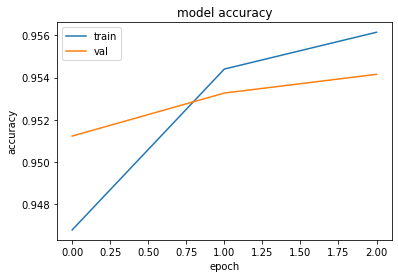

In [139]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [140]:
preds = model.predict(X_valid).reshape(-1)

In [141]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61201
           1       0.69      0.50      0.58      4106

    accuracy                           0.95     65307
   macro avg       0.83      0.74      0.78     65307
weighted avg       0.95      0.95      0.95     65307



с усреднением эмбедингов: 

In [142]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='selu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [154]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=3)

Epoch 1/3
2424/2424 [==============================] - 21s 9ms/step - loss: 0.1172 - accuracy: 0.9539 - val_loss: 0.1191 - val_accuracy: 0.9529
Epoch 2/3
2424/2424 [==============================] - 21s 9ms/step - loss: 0.1125 - accuracy: 0.9552 - val_loss: 0.1182 - val_accuracy: 0.9536
Epoch 3/3
2424/2424 [==============================] - 23s 9ms/step - loss: 0.1101 - accuracy: 0.9558 - val_loss: 0.1163 - val_accuracy: 0.9540


In [155]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


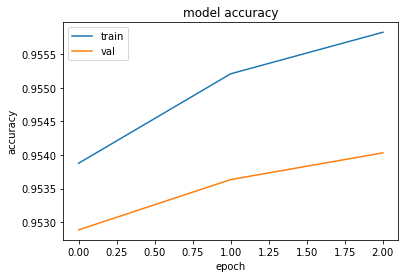

In [156]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [157]:
preds = model.predict(X_valid).reshape(-1)

In [158]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61201
           1       0.67      0.52      0.59      4106

    accuracy                           0.95     65307
   macro avg       0.82      0.75      0.78     65307
weighted avg       0.95      0.95      0.95     65307



со сложением эмбедингов: 

In [159]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings)
dense = tf.keras.layers.Dense(70, activation='tanh')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [160]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=3)

Epoch 1/3
2424/2424 [==============================] - 22s 9ms/step - loss: 0.2248 - accuracy: 0.9121 - val_loss: 0.1276 - val_accuracy: 0.9500
Epoch 2/3
2424/2424 [==============================] - 22s 9ms/step - loss: 0.1195 - accuracy: 0.9529 - val_loss: 0.1193 - val_accuracy: 0.9520
Epoch 3/3
2424/2424 [==============================] - 22s 9ms/step - loss: 0.1132 - accuracy: 0.9546 - val_loss: 0.1174 - val_accuracy: 0.9530


In [161]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


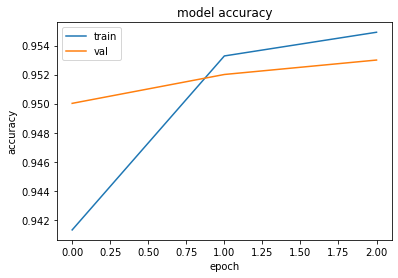

In [162]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [163]:
preds = model.predict(X_valid).reshape(-1)

In [164]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     61201
           1       0.68      0.47      0.56      4106

    accuracy                           0.95     65307
   macro avg       0.82      0.73      0.77     65307
weighted avg       0.95      0.95      0.95     65307



2) В одной из задач используйте сразу две предобученные эмбединг модели (можно фастекст и ворд2век, а можно просто 2 фастекста с разными параметрами) в одной нейронке (имеется в виду предобученные до обучения нейронки, т.е вы можете сами обучить фастекст/ворд2век и не искать готовые модели в интернете). Попробуйте усреднять эмбединги и конкатенировать (общие эмбединги потом в один вектор собирайте любым способом - например, тем который оказался лучше в первой задаче). Подсказка: используйте functional api, сделайте два Embedding слоя и к их выходам примените слой Concatenate([emb1, emb2)) или Average([emb1, emb2))

Бонусный балл можно получить за добавление к пайплайну subword токенизации (через библиотеку tokenizers например)

Лучше делать задание на второй задаче, так как в Авито в любом случае разница будет в несколько десятых процентов.



In [302]:
from tokenizers import CharBPETokenizer, Tokenizer

In [303]:
quora['question_text'].to_csv('corpus.txt', index=None)
tok_sub = CharBPETokenizer()
tok_sub.train('corpus.txt', vocab_size=2000, min_frequency=10,)

In [304]:
word2id = tok_sub.get_vocab()

In [305]:
data = quora['question_text']

In [306]:
X = []

for text in data:
    tokens = tok_sub.encode(text).tokens
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [307]:
MAX_LEN = max(len(x) for x in X)

MAX_LEN

858

In [308]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

X.shape

(1306122, 858)

In [309]:
random.seed(42)

In [310]:
y = quora.target.values

In [311]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [312]:
texts = quora.question_text.apply(preprocess).tolist()

In [313]:
ft1 = gensim.models.FastText(texts, vector_size=100, window=3, min_count=1)

weights1 = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights1[i] = ft1.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights1[i] = ft1.wv['опрагпллирао']

In [314]:
weights1.shape

(2000, 100)

In [315]:
ft2 = gensim.models.FastText(texts, vector_size=100, window=4, min_count=3)

weights2 = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights2[i] = ft2.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights2[i] = ft2.wv['опрагпллирао']

С конкатенированием

In [319]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
ft1_embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                           weights=[weights1])(inputs, )
ft2_embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                           weights=[weights2])(inputs, )
concatenated_embeddings = tf.keras.layers.Concatenate(axis=1)([ft1_embeddings, ft2_embeddings])
flat = tf.keras.layers.Flatten()(concatenated_embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(flat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [320]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=100,
          epochs=5)

Epoch 1/5
12409/12409 [==============================] - 604s 49ms/step - loss: 0.7444 - accuracy: 0.9199 - val_loss: 0.2089 - val_accuracy: 0.9390
Epoch 2/5
12409/12409 [==============================] - 619s 50ms/step - loss: 0.2132 - accuracy: 0.9384 - val_loss: 0.2151 - val_accuracy: 0.9390
Epoch 3/5
12409/12409 [==============================] - 691s 56ms/step - loss: 0.2109 - accuracy: 0.9377 - val_loss: 0.2022 - val_accuracy: 0.9390
Epoch 4/5
12409/12409 [==============================] - 680s 55ms/step - loss: 0.2078 - accuracy: 0.9379 - val_loss: 0.2023 - val_accuracy: 0.9390
Epoch 5/5
12409/12409 [==============================] - 670s 54ms/step - loss: 0.2059 - accuracy: 0.9381 - val_loss: 0.2078 - val_accuracy: 0.9390


In [321]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


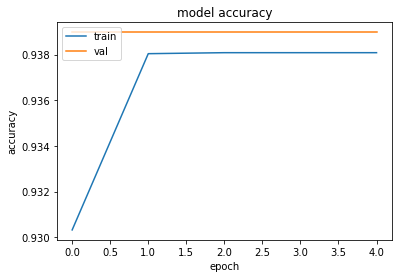

In [322]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [323]:
preds = model.predict(X_valid)

In [324]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(y_valid, (preds > 0.5).astype(float)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     61322
           1       0.00      0.00      0.00      3985

    accuracy                           0.94     65307
   macro avg       0.47      0.50      0.48     65307
weighted avg       0.88      0.94      0.91     65307



/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

С усреднением

In [335]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
ft1_embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                          weights=[weights1])(inputs, )
ft2_embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                          weights=[weights2])(inputs, )
embeddings_average = tf.keras.layers.Average()([ft1_embeddings, ft2_embeddings])
flat = tf.keras.layers.Flatten()(embeddings_average)
dense = tf.keras.layers.Dense(64, activation='selu')(flat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [336]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=100,
          epochs=2)

Epoch 1/2
12409/12409 [==============================] - 432s 35ms/step - loss: 0.5274 - accuracy: 0.9356 - val_loss: 0.2110 - val_accuracy: 0.9390
Epoch 2/2
12409/12409 [==============================] - 428s 35ms/step - loss: 0.2137 - accuracy: 0.9379 - val_loss: 0.2067 - val_accuracy: 0.9390


In [337]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


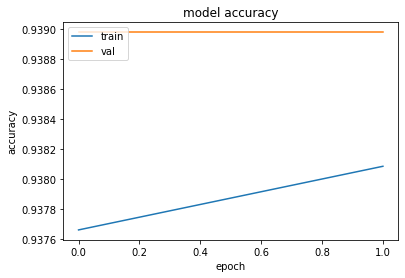

In [338]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [340]:
preds = model.predict(X_valid)

In [341]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     61322
           1       0.00      0.00      0.00      3985

    accuracy                           0.94     65307
   macro avg       0.47      0.50      0.48     65307
weighted avg       0.88      0.94      0.91     65307



/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Не очень получилось, но я не знаю, почему, пробовала по-разному :(